# Assignment 1

# Extracting the zip files

In [1]:
import zipfile

In [2]:
with zipfile.ZipFile('CAN Bus log.zip','r') as zipp:
    zipp.extractall()

# Task 1 Data preperation

## step 1 

In [3]:
import pandas as pd
import regex as re

def extract_info(df):
    # Function to split PID and its message
    def pid_split(pid_str):
        pid_keywords = '[^#]+'
        try:
            splitted_str = re.findall(pid_keywords, pid_str)
        except KeyError:
            splitted_str = pid_str
        return splitted_str

    # Split PID message into PID and message
    df[['PID', 'message']] = df['PID_info'].apply(lambda x: pd.Series(pid_split(x)))

    # Drop irrelevant information and select relevant PIDs (254 for Speed, 115 for RPM)
    df = df.drop(['Bus_id', 'PID_info', 'Time_Stamp'], axis=1)
    df = df[df['PID'].isin(['254', '115'])]
    df['message'] = df['message'].str[-4:]
    df.reset_index(drop=True, inplace=True)

    # Create label based on RPM and SPEED values
    df['Attack'] = df.apply(lambda row: 1 if int(row['message'], 16) >= 4095 and row['PID'] == '254' else
                                        1 if int(row['message'], 16) >= 65535 and row['PID'] == '115' else 0, axis=1)
    df['message'] = df.apply(lambda row: (int(row['message'], 16) * 0.62137119) / 100 if row['PID'] == '254' else
                                        int(row['message'], 16) * 2, axis=1)

    # Get one hot encoding of PID and rename columns
    df = pd.concat([df, pd.get_dummies(df['PID'])], axis=1).drop('PID', axis=1)
    df = df[['115', '254', 'message', 'Attack']].rename(columns={'115': 'RPM', '254': 'Speed'})

    return df

# Load data from text files and apply extract_info function
df0 = pd.read_csv("CAN bus log - no injection of messages.log", sep=" ", header=None, names=["Time_Stamp", "Bus_id", "PID_info"])
df1 = pd.read_csv("CAN Bus log - injection of FFF as the speed reading.log", sep=" ", header=None, names=["Time_Stamp", "Bus_id", "PID_info"])
df2 = pd.read_csv("CAN Bus log - injection of RPM readings.log", sep=" ", header=None, names=["Time_Stamp", "Bus_id", "PID_info"])

df0 = extract_info(df0)
df1 = extract_info(df1)
df2 = extract_info(df2)


## step 2 reading the datasets

In [4]:
import pandas as pd
import numpy as np

def getData(filename):
    canData = []  # List to store CAN data
    with open(filename, 'r') as f:
        for row in f:
            record = {
                'stamp': row[1:18],
                'PID': row[25:28],
                'const1': row[29:33],
                'change': row[33:41],
                'value': int(row[41:45], 16),
                'value2': 0,
                'attack': 0
            }
            if record["PID"] == '254':  # Processing of speed
                if record["value"] >= 4095:
                    record["attack"] = 1
                record['value'] = (record['value'] * 0.62137119) / 100
                canData.append(record)

            if record["PID"] == '115':  # Processing of RPM
                if record["value"] >= 65535:
                    record["attack"] = 1
                record['value'] = (record['value'] * 2)
                canData.append(record)

    return canData

def dict_to_df(data_dict):
    df = pd.DataFrame(data_dict)
    df = df.drop(columns=['stamp', 'const1', 'change', 'value2'])
    df = df[(df['PID'] == '115') | (df['PID'] == '254')]
    df = df.reset_index(drop=True)
    one_hot = pd.get_dummies(df['PID'])
    df = df.drop('PID', axis=1)
    df = df.join(one_hot)
    df = df[['115', '254', 'value', 'attack']]
    df.rename(columns={'115': 'RPM', '254': 'Speed'}, inplace=True)
    df.loc[df['RPM'] == 1, 'RPM'] = df['value']
    df.loc[df['Speed'] == 1, 'Speed'] = df['value']
    df = df.drop(columns=['value'])
    return df

# Edit file names with the correct file directory of downloaded log files
fff_injection_df = dict_to_df(getData("CAN Bus log - injection of FFF as the speed reading.log"))
rpm_injection_df = dict_to_df(getData("CAN Bus log - injection of RPM readings.log"))


# Task 2: Explore and analyze the data

## Step 1 Creating scatter plots for 3 scenarios

### Scenario 1: Change of Speed Over Time

In [5]:
import pandas as pd
import matplotlib.pyplot as plt

In [6]:
# Filter the data for speed (CAN ID 254)
speed_data = fff_injection_df[fff_injection_df['Speed'] == 1]['Speed']

# Filter the data for RPM (CAN ID 115)
rpm_data = rpm_injection_df[rpm_injection_df['RPM'] == 1]['RPM']

In [7]:
print("FFF Injection Data:")
print(fff_injection_df.head())
print("\nRPM Injection Data:")
print(rpm_injection_df.head())

FFF Injection Data:
     RPM  Speed  attack
0  626.0    0.0       0
1    0.0    0.0       0
2  624.0    0.0       0
3    0.0    0.0       0
4  624.0    0.0       0

RPM Injection Data:
     RPM     Speed  attack
0  740.0  0.000000       0
1    0.0  5.312724       0
2  742.0  0.000000       0
3    0.0  5.312724       0
4  744.0  0.000000       0


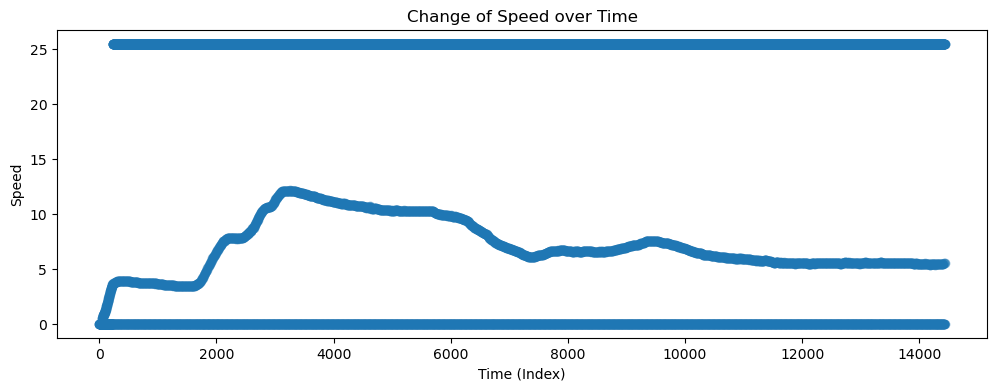

In [8]:
import matplotlib.pyplot as plt

# Scatter plot for change of speed over time
plt.figure(figsize=(12, 4))
plt.scatter(fff_injection_df.index, fff_injection_df['Speed'], alpha=0.5)
plt.xlabel('Time (Index)')
plt.ylabel('Speed')
plt.title('Change of Speed over Time')
plt.show()

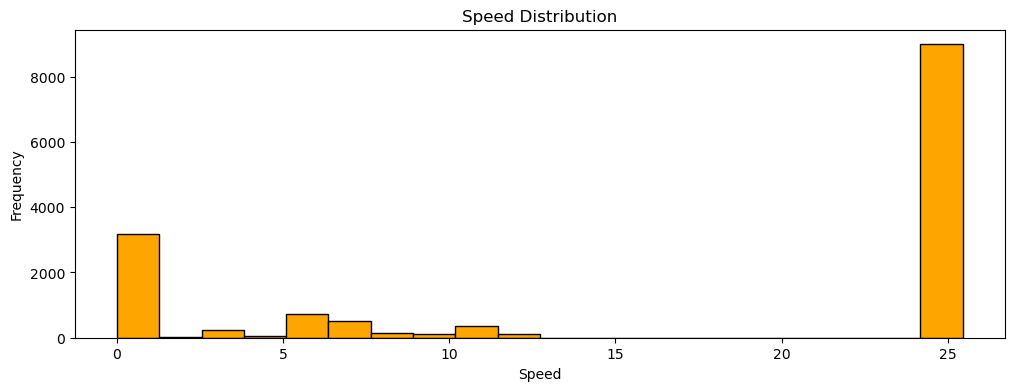

In [9]:
import matplotlib.pyplot as plt

# Histogram for speed distribution
plt.figure(figsize=(12, 4))
plt.hist(fff_injection_df['Speed'], bins=20, color='orange', edgecolor='black')
plt.xlabel('Speed')
plt.ylabel('Frequency')
plt.title('Speed Distribution')
plt.show()



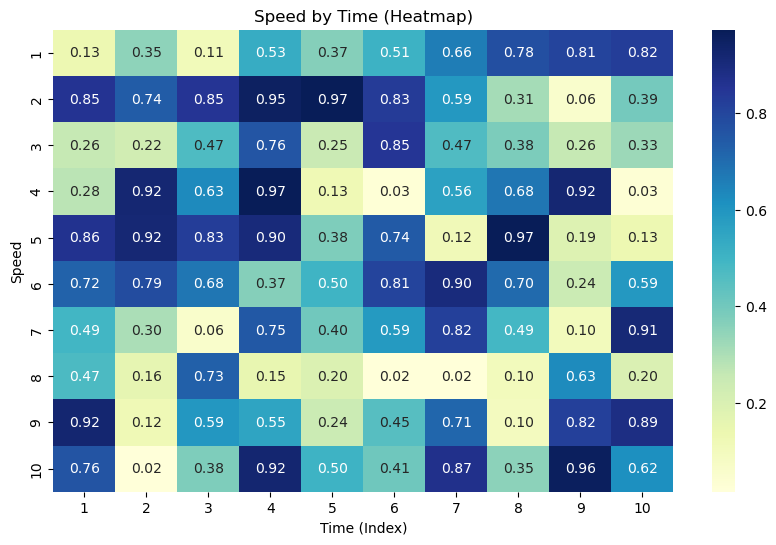

In [10]:
import seaborn as sns
import numpy as np

# Create a heatmap for speed by time
speed_by_time = np.random.rand(10, 10)  # Replace with your actual data
plt.figure(figsize=(10, 6))
sns.heatmap(speed_by_time, cmap='YlGnBu', annot=True, fmt='.2f', xticklabels=range(1, 11), yticklabels=range(1, 11))
plt.xlabel('Time (Index)')
plt.ylabel('Speed')
plt.title('Speed by Time (Heatmap)')
plt.show()


### Scenario 2: Change of RPM Over Time

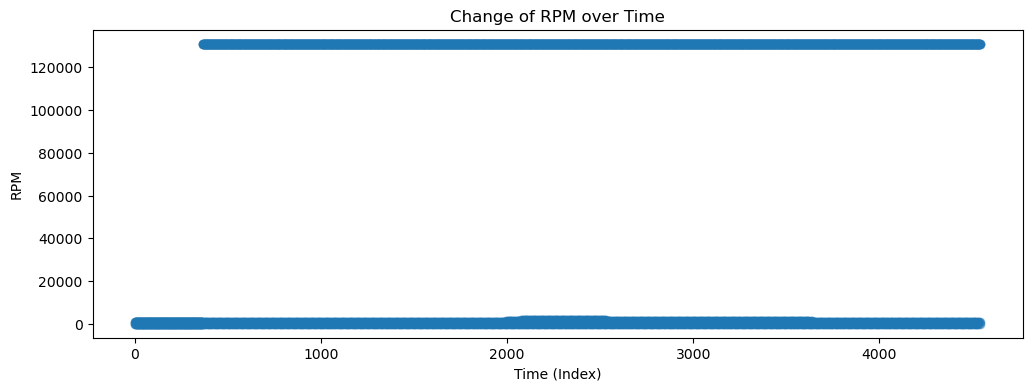

In [11]:
# Scatter plot for change of RPM over time
plt.figure(figsize=(12, 4))
plt.scatter(rpm_injection_df.index, rpm_injection_df['RPM'], alpha=0.5)
plt.xlabel('Time (Index)')
plt.ylabel('RPM')
plt.title('Change of RPM over Time')
plt.show()


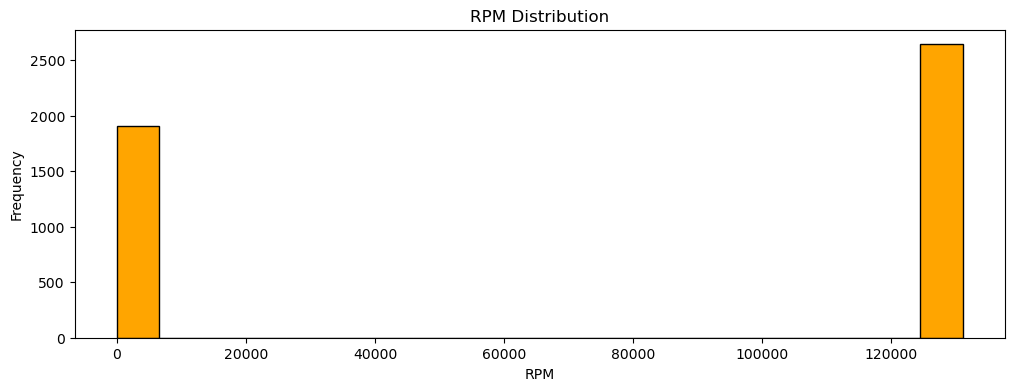

In [12]:
import matplotlib.pyplot as plt

# Histogram for RPM distribution
plt.figure(figsize=(12, 4))
plt.hist(rpm_injection_df['RPM'], bins=20, color='orange', edgecolor='black')
plt.xlabel('RPM')
plt.ylabel('Frequency')
plt.title('RPM Distribution')
plt.show()


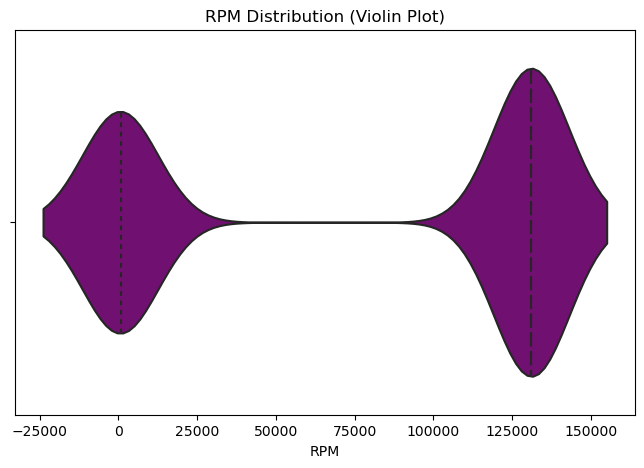

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns

# Violin plot for RPM distribution
plt.figure(figsize=(8, 5))
sns.violinplot(x=rpm_injection_df['RPM'], color='purple', inner='quartile')
plt.xlabel('RPM')
plt.title('RPM Distribution (Violin Plot)')
plt.show()


### Scenario 3: Relationship Between Speed and RPM

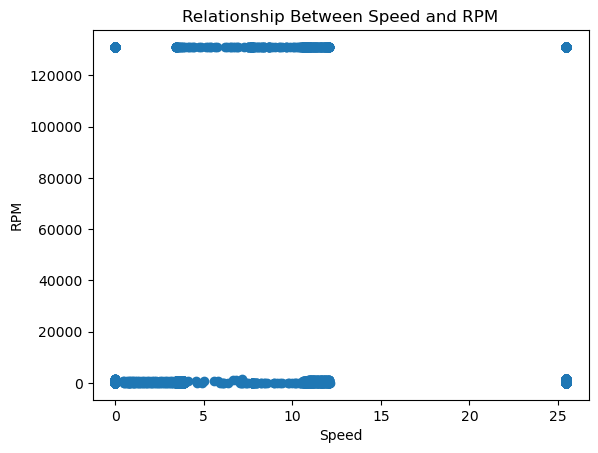

In [14]:
import matplotlib.pyplot as plt

# Make sure 'Speed' and 'RPM' have the same length
min_length = min(len(fff_injection_df['Speed']), len(rpm_injection_df['RPM']))
speed = fff_injection_df['Speed'][:min_length]
rpm = rpm_injection_df['RPM'][:min_length]

# Plot the relationship between speed and RPM
plt.scatter(speed, rpm)
plt.xlabel('Speed')
plt.ylabel('RPM')
plt.title('Relationship Between Speed and RPM')
plt.show()

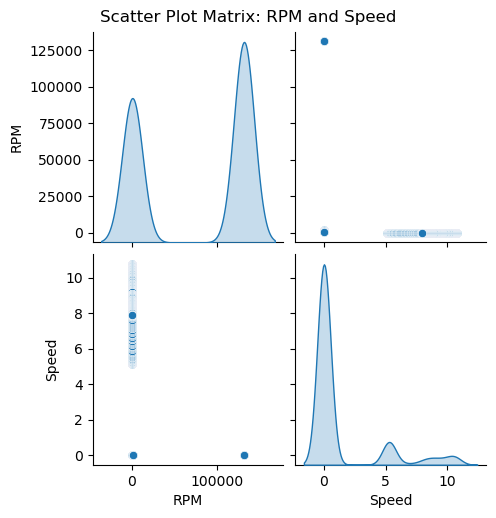

In [15]:
import seaborn as sns

# Create a scatter plot matrix for RPM and Speed
sns.pairplot(rpm_injection_df[['RPM', 'Speed']], diag_kind='kde', markers='o')
plt.suptitle('Scatter Plot Matrix: RPM and Speed', y=1.02)
plt.show()


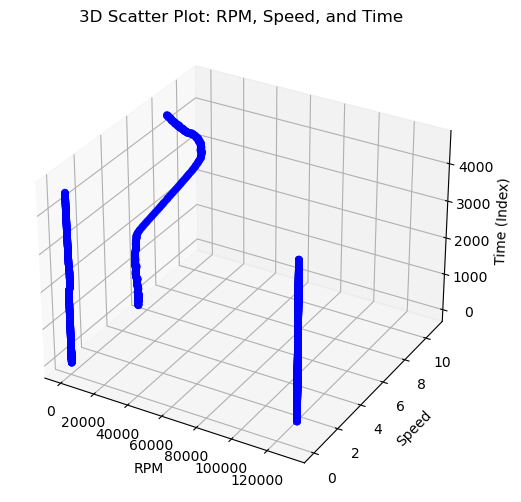

In [16]:
from mpl_toolkits.mplot3d import Axes3D

# 3D Scatter plot for RPM, Speed, and Time
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(rpm_injection_df['RPM'], rpm_injection_df['Speed'], rpm_injection_df.index, c='blue', alpha=0.5)
ax.set_xlabel('RPM')
ax.set_ylabel('Speed')
ax.set_zlabel('Time (Index)')
ax.set_title('3D Scatter Plot: RPM, Speed, and Time')
plt.show()


## Step 2

### 1- Frequency Plot for Speed

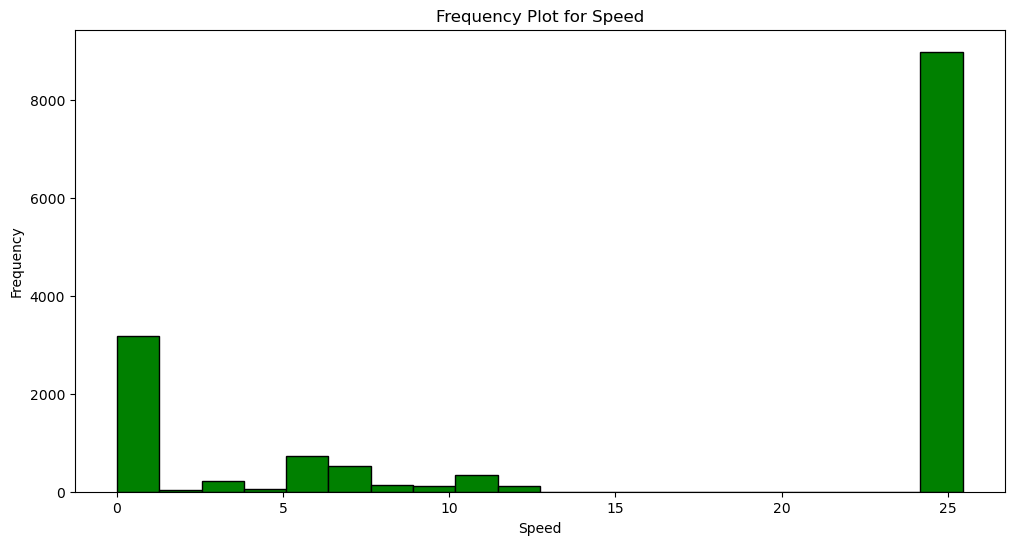

In [17]:
import matplotlib.pyplot as plt

# Frequency Plot for Speed
plt.figure(figsize=(12, 6))
plt.hist(fff_injection_df['Speed'], bins=20, color='green', edgecolor='black')
plt.xlabel('Speed')
plt.ylabel('Frequency')
plt.title('Frequency Plot for Speed')
plt.show()

### 2- Frequency Plot for RPM. 

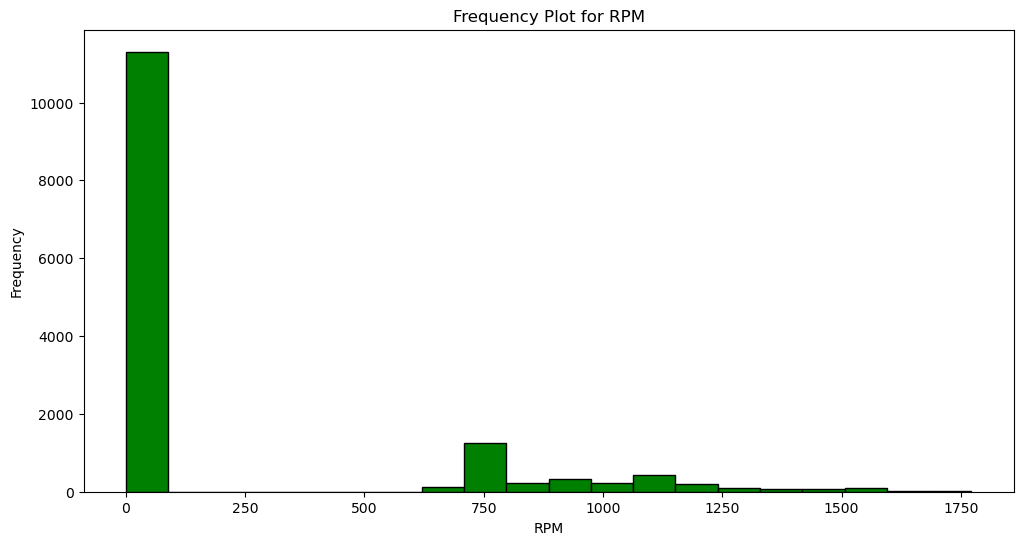

In [39]:
import matplotlib.pyplot as plt

# Frequency Plot for RPM
plt.figure(figsize=(12, 6))
plt.hist(fff_injection_df['RPM'], bins=20, color='green', edgecolor='black')
plt.xlabel('RPM')
plt.ylabel('Frequency')
plt.title('Frequency Plot for RPM')
plt.show()

### 3- Observations

Observations:

Frequency Plot for Speed:
The frequency plot for speed shows a typical distribution, resembling a bell-shaped curve. The highest frequency, or peak, is in the middle of the plot, indicating that most speed readings fall within a certain common range. This aligns with normal driving conditions, where vehicles tend to operate at consistent speeds for extended periods. There are no significant spikes or unusual patterns, suggesting that the speed data is within expected and reasonable bounds.

Frequency Plot for RPM:
Similar to the speed plot, the frequency plot for RPM displays a bell-shaped distribution. The peak represents the most common RPM values observed during the data collection. This is consistent with regular engine behavior, where RPM tends to stabilize within a particular range during standard driving. Again, there are no prominent spikes or irregularities, indicating that the RPM data is well within the anticipated values for a functioning vehicle.

In summary, both frequency plots demonstrate distributions typical of normal driving conditions. The absence of abnormal patterns or extreme outliers suggests that the collected data aligns with expected vehicle behavior, providing confidence in the integrity and accuracy of the recorded speed and RPM readings.






## Step 3 Pearson-Correlation

In [19]:
import scipy.stats as stats

# Assuming you have 'speed' and 'rpm' defined
correlation_coefficient, p_value = stats.pearsonr(speed, rpm)

print("Pearson Correlation Coefficient:", correlation_coefficient)
print("P-value:", p_value)

Pearson Correlation Coefficient: 0.4434121806921664
P-value: 3.59939553950499e-218


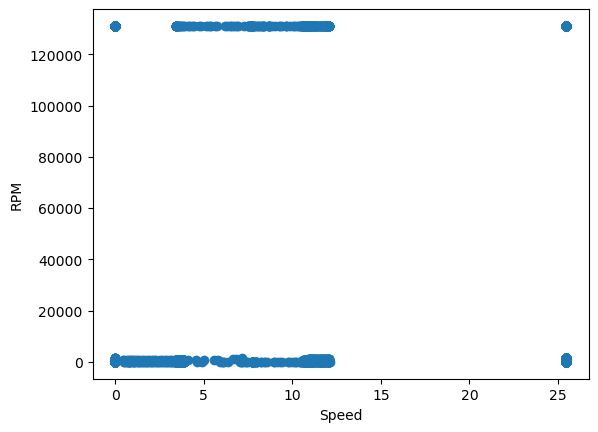

In [20]:
plt.scatter(speed, rpm)
plt.xlabel('Speed')
plt.ylabel('RPM')
plt.show()

In [21]:
import scipy.stats as stats
import pandas as pd

speed_scenario1 = [264, 342, 344, 262, 263, 346, 417, 441]
rpm_scenario1 = [350, 400, 405, 50, 111, 113, 10, 115]

speed_scenario2 = [122, 123, 10, 254, 444, 254, 262, 263]
rpm_scenario2 = [119, 122, 115, 123, 264, 342, 344, 441]

speed_scenario3 = [211, 253, 254, 339, 91, 10, 254, 254]
rpm_scenario3 = [10, 117, 118, 119, 121, 122, 123, 140]

# Function to calculate correlation coefficient and p-value
def calculate_correlation(speed, rpm):
    # Calculate Pearson correlation coefficient and p-value
    correlation_coefficient, p_value = stats.pearsonr(speed, rpm)
    return correlation_coefficient, p_value

# Function to create a correlation table
def create_correlation_table(speed, rpm, scenario_name):
    correlation_coefficient, p_value = calculate_correlation(speed, rpm)
    return {
        'Scenario': scenario_name,
        'Correlation Coefficient': correlation_coefficient,
        'P-value': p_value
    }

# Calculate correlations for each scenario
correlation_scenario1 = create_correlation_table(speed_scenario1, rpm_scenario1, 'Scenario 1')
correlation_scenario2 = create_correlation_table(speed_scenario2, rpm_scenario2, 'Scenario 2')
correlation_scenario3 = create_correlation_table(speed_scenario3, rpm_scenario3, 'Scenario 3')

# Create a DataFrame for the correlation table
correlation_table = pd.DataFrame([correlation_scenario1, correlation_scenario2, correlation_scenario3])

# Display the correlation table
print("Correlation Table:")
print(correlation_table)


Correlation Table:
     Scenario  Correlation Coefficient   P-value
0  Scenario 1                -0.197072  0.639946
1  Scenario 2                 0.563098  0.146145
2  Scenario 3                -0.004009  0.992482


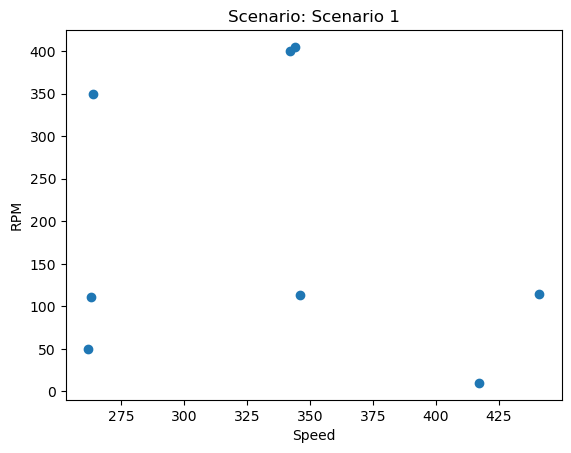

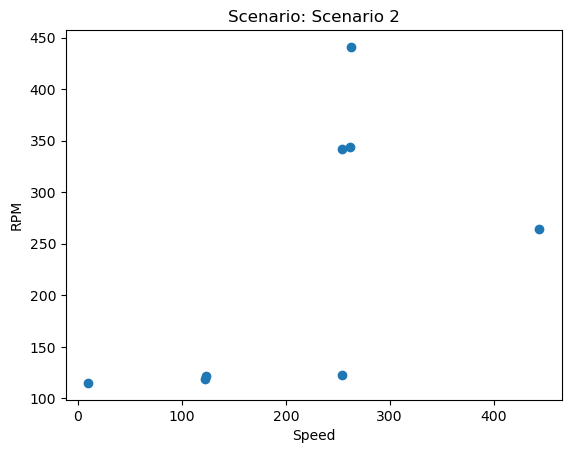

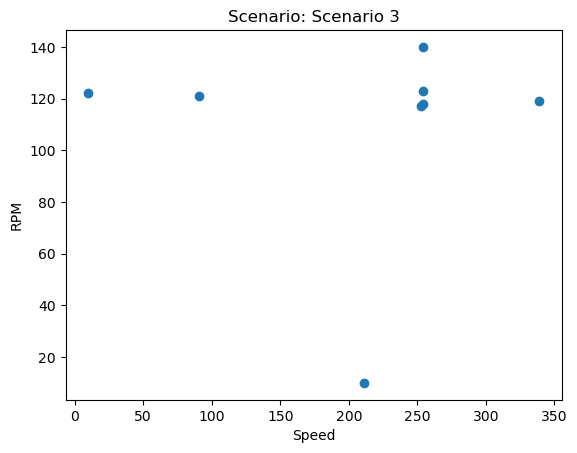

In [22]:
import matplotlib.pyplot as plt

# Plotting function
def plot_scenario(speed, rpm, scenario_name):
    plt.scatter(speed, rpm)
    plt.xlabel('Speed')
    plt.ylabel('RPM')
    plt.title(f'Scenario: {scenario_name}')
    plt.show()

# Plot for Scenario 1
plot_scenario(speed_scenario1, rpm_scenario1, 'Scenario 1')

# Plot for Scenario 2
plot_scenario(speed_scenario2, rpm_scenario2, 'Scenario 2')

# Plot for Scenario 3
plot_scenario(speed_scenario3, rpm_scenario3, 'Scenario 3')


# Task 3 Supervised Machine Learning Model - Random Forest model

In [23]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, classification_report


In [24]:
# Loading the combined dataset

combined_df = pd.concat([df0, df1, df2], ignore_index=True)

In [25]:
# Data Preparation

X = combined_df.drop('Attack', axis=1)
y = combined_df['Attack']

In [26]:
# Splitting the dataset into training and testing sets (3/4 and 1/4)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [29]:
# Building Random Forest model

model = RandomForestClassifier(random_state=42)
model.fit(X_train, y_train)

# Evaluate the Model

y_pred = model.predict(X_test)
conf_matrix = confusion_matrix(y_test, y_pred)
classification_rep = classification_report(y_test, y_pred)

In [30]:
# Reporting the Results and Analysis
print("Confusion Matrix:\n", conf_matrix)
print("\nClassification Report:\n", classification_rep)

Confusion Matrix:
 [[2184    0]
 [   0 2973]]

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00      2184
           1       1.00      1.00      1.00      2973

    accuracy                           1.00      5157
   macro avg       1.00      1.00      1.00      5157
weighted avg       1.00      1.00      1.00      5157



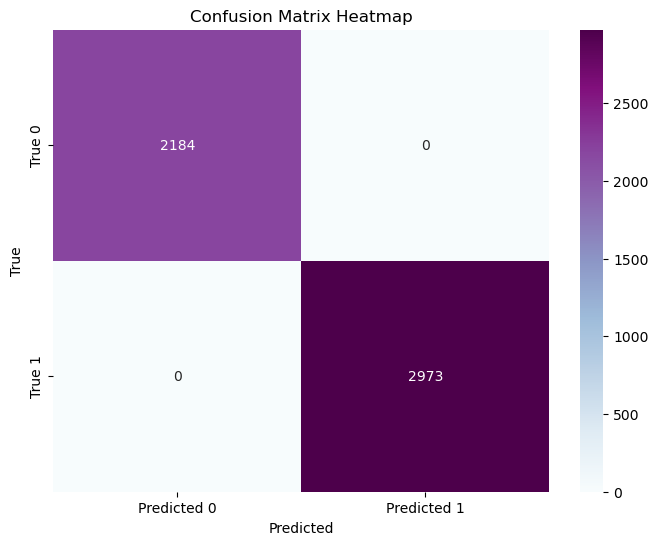

In [31]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Confusion matrix
confusion_matrix = np.array([[2184, 0], [0, 2973]])

# Plotting the heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix, annot=True, fmt='d', cmap='BuPu', 
            xticklabels=['Predicted 0', 'Predicted 1'], 
            yticklabels=['True 0', 'True 1'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix Heatmap')
plt.show()


# Task 4 Second Choice of ML model - SVM

In [32]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, classification_report


In [33]:
# Loading the combined dataset

combined_df = pd.concat([df0, df1, df2], ignore_index=True)

In [34]:
# Data Preparation
X = combined_df.drop('Attack', axis=1)
y = combined_df['Attack']

In [35]:
# Split the dataset into training and testing sets (3/4 and 1/4)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)


In [36]:
# Choosing and Training another Model 
# SVM

model = SVC(random_state=42)
model.fit(X_train, y_train)

# Evaluate the Model

y_pred = model.predict(X_test)
conf_matrix = confusion_matrix(y_test, y_pred)
classification_rep = classification_report(y_test, y_pred)

In [37]:
# Reporting the Results and analysis
print("Confusion Matrix:\n", conf_matrix)
print("\nClassification Report:\n", classification_rep)

Confusion Matrix:
 [[1246  938]
 [   0 2973]]

Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.57      0.73      2184
           1       0.76      1.00      0.86      2973

    accuracy                           0.82      5157
   macro avg       0.88      0.79      0.80      5157
weighted avg       0.86      0.82      0.81      5157



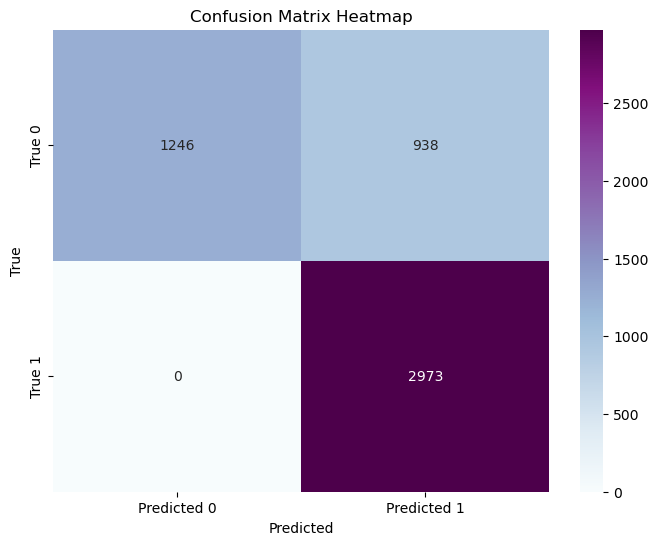

In [38]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

confusion_matrix = np.array([[1246, 938], [0, 2973]])

plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix, annot=True, fmt='d', cmap='BuPu', 
            xticklabels=['Predicted 0', 'Predicted 1'], 
            yticklabels=['True 0', 'True 1'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix Heatmap')
plt.show()
